In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from src.dataframe import importDfPickle

import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

/home/eduardo/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=importDfPickle("./output/breast_cancer_2000m.pkl")

In [3]:
df.head()

,label,image,path
0,1,"[[[222, 212, 239], [230, 224, 245], [235, 231,...",images/1/12867_idx5_x1851_y1351_class1.png
1,1,"[[[194, 170, 222], [188, 167, 219], [192, 171,...",images/1/16167_idx5_x2201_y1701_class1.png
2,1,"[[[160, 117, 172], [159, 127, 207], [158, 116,...",images/1/12821_idx5_x1651_y1551_class1.png
3,1,"[[[220, 204, 226], [229, 223, 241], [223, 205,...",images/1/13691_idx5_x3651_y1901_class1.png
4,1,"[[[169, 123, 176], [132, 86, 134], [136, 83, 1...",images/1/14154_idx5_x1801_y1501_class1.png


In [6]:
#df['label']=df['label'].replace(1,'Negativo')

In [7]:
#df['label']=df['label'].replace(0,'Positivo')

In [4]:
#df.head()

In [9]:
#df['label']=df['label'].replace('Negativo',0)

In [10]:
#df['label']=df['label'].replace('Positivo',1)

In [5]:
#df.head()

### Haciendo la transformada de Fourier de las imágenes

In [6]:
from scipy.fftpack import fft

def fftransform(array):
    '''fft to all the array images (column in this case)'''
    return np.abs(fft(array,512))


In [ ]:
df['fft']=df['image'].apply(lambda x: fftransform(x))

In [12]:
X=np.asarray(list(df['image']))
X = X.reshape(X.shape[0], -1)
y=np.asarray(df['label'])

In [13]:
X.shape

(20000, 7500)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=250)

# fit the training data to the model
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
clf_pred = clf.predict(X_test)

In [27]:
clf.predict_proba(X_test)[0:10]

array([[0.356, 0.644],
       [0.656, 0.344],
       [0.588, 0.412],
       [0.864, 0.136],
       [0.156, 0.844],
       [0.092, 0.908],
       [0.1  , 0.9  ],
       [0.492, 0.508],
       [0.264, 0.736],
       [0.628, 0.372]])

In [28]:
y_test[0:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [29]:
clf_pred[0:10]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0])

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score

print("Mean Absolute Error is :", mean_absolute_error(y_test, clf_pred))
print('Mean Squared Error is :', mean_squared_error(y_test, clf_pred))
print('The R2 score value is :', r2_score(y_test, clf_pred)*100)
print("Accuracy:", accuracy_score(y_test,clf_pred))

Mean Absolute Error is : 0.187
Mean Squared Error is : 0.187
The R2 score value is : 25.193248690694325
Accuracy: 0.813


In [31]:
df_prueba = pd.DataFrame(list(zip(clf_pred , y_test)), 
               columns =['pred', 'lo que es']) 

In [52]:
df_prueba.head(20)

,pred,lo que es
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,1,0
8,1,1
9,0,0


In [33]:
import numpy as np
scores = pd.DataFrame({
    "predicted":clf_pred,
    "gt":y_test
})
scores["diff"] = np.abs(scores["predicted"]-scores["gt"])
scores["diff"].sum()/ len(y_test)

0.187

,gt,predicted,proba Beningno,proba Maligno
0,1,1,0.356,0.644
1,0,0,0.656,0.344
2,0,0,0.588,0.412
3,0,0,0.864,0.136
4,1,1,0.156,0.844


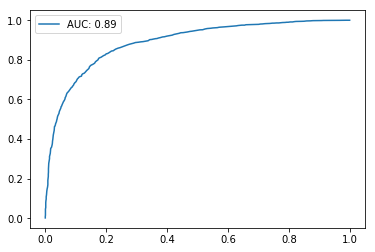

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_score = clf.predict_proba(X_test)

#print(y_score)
roc = roc_curve(y_test, y_score[:,1])
display(pd.DataFrame({
    "gt":y_test,
    "predicted":clf_pred,
    "proba Maligno":y_score[:,1],
    "proba Beningno":y_score[:,0]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test, y_score[:,1]),2))])


In [51]:
pd.crosstab(y_test, clf_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,1686,333
1,415,1566


### Predicción con nuevas imágenes

In [35]:
import cv2
def resizeImages(img_path,size=(50,50)):
    "resize all images to 50x50"
    image = cv2.imread(img_path)
    resized = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)
    #print('resized image')
    return resized

In [49]:
def predictNewImage(path):
    im = resizeImages(path)
    pred_nueva=clf.predict(im)
    return "Probs -> Benign:{0:.5f} Malignant:{1:.5f}".format(pred_nueva[0],pred_nueva[1])

In [84]:
path='./images/16896_idx5_x201_y1051_class1.png'



image = cv2.imread(path)
resized = cv2.resize(image,(50,50), interpolation=cv2.INTER_CUBIC)
#pred_nueva=clf.predict(resized)
resized.shape

(50, 50, 3)

In [79]:
pred=predictNewImage('./images/16896_idx5_x201_y1051_class1.png')

ValueError: Found array with dim 3. Estimator expected <= 2.

NameError: name 'pred' is not defined